In [1]:
!conda install pytorch torchvision torchaudio cpuonly -c pytorch

Channels:
 - pytorch
 - defaults
Platform: win-64
Solving environment: ...working... done

# All requested packages already installed.



In [2]:
!pip install pycocotools

In [3]:
import os
import json
from PIL import Image
import torch
from torchvision.io import read_image
from torchvision.transforms import functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO


In [4]:
# Specify paths to train and test data
TRAIN_IMG_DIR = 'data/images/train/'  # Directory containing training images
TEST_IMG_DIR = 'data/images/test/'    # Directory containing testing images
TRAIN_ANN_FILE = 'data/annotations/tomatOD_train.json'  # Path to train COCO annotations
TEST_ANN_FILE = 'data/annotations/tomatOD_test.json'    # Path to test COCO annotations

# Load COCO datasets for train and test
train_coco = COCO(TRAIN_ANN_FILE)
test_coco = COCO(TEST_ANN_FILE)

# Display basic statistics for train dataset
train_image_ids = train_coco.getImgIds()
train_annotations = train_coco.loadAnns(train_coco.getAnnIds())
print(f"Train Dataset - Number of Images: {len(train_image_ids)}")
print(f"Train Dataset - Number of Annotations: {len(train_annotations)}")

# Display basic statistics for test dataset
test_image_ids = test_coco.getImgIds()
test_annotations = test_coco.loadAnns(test_coco.getAnnIds())
print(f"Test Dataset - Number of Images: {len(test_image_ids)}")
print(f"Test Dataset - Number of Annotations: {len(test_annotations)}")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Train Dataset - Number of Images: 222
Train Dataset - Number of Annotations: 1953
Test Dataset - Number of Images: 55
Test Dataset - Number of Annotations: 468


In [5]:
# Define the custom dataset class
class TomatoDataset(Dataset):
    def __init__(self, img_dir, ann_file, transform=None):
        """
        Args:
            img_dir (str): Directory containing the images.
            ann_file (str): Path to the COCO annotation file.
            transform (callable, optional): Transformations to apply to the images.
        """
        self.img_dir = img_dir
        self.transform = transform
        self.coco = COCO(ann_file)
        self.image_ids = self.coco.getImgIds()

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        """
        Retrieve an image and its annotations.

        Args:
            idx (int): Index of the image.

        Returns:
            image (torch.Tensor): Transformed image tensor.
            target (dict): Dictionary with 'boxes' (bounding boxes) and 'labels' (class labels).
        """
        # Load image information
        img_id = self.image_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        image = Image.open(img_path).convert("RGB")  # Load image as PIL Image

        # Load annotations
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        annotations = self.coco.loadAnns(ann_ids)

        # Extract bounding boxes and labels
        boxes = [ann['bbox'] for ann in annotations]
        labels = [ann['category_id'] for ann in annotations]

        # Normalize bounding boxes relative to image size
        img_width, img_height = img_info['width'], img_info['height']
        boxes = [
            [
                bbox[0] / img_width,
                bbox[1] / img_height,
                (bbox[0] + bbox[2]) / img_width,
                (bbox[1] + bbox[3]) / img_height,
            ]
            for bbox in boxes
        ]

        # Convert bounding boxes and labels to tensors
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        target = {'boxes': boxes, 'labels': labels}

        # Apply transformations to the image
        if self.transform:
            image = self.transform(image)

        return image, target

In [6]:
# Paths for train and test datasets
train_img_dir = 'data/images/train/'
train_ann_file = 'data/annotations/tomatOD_train.json'
test_img_dir = 'data/images/test/'
test_ann_file = 'data/annotations/tomatOD_test.json'

In [8]:
# Create datasets with appropriate transforms
train_dataset = TomatoDataset(img_dir=train_img_dir, ann_file=train_ann_file)
test_dataset = TomatoDataset(img_dir=test_img_dir, ann_file=test_ann_file)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [9]:
# Define custom collate function for batching
def collate_fn(batch):
    return tuple(zip(*batch))

In [10]:
# Create DataLoaders for train and test datasets
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

In [11]:
# Example: Display a single batch from the train DataLoader
for images, targets in train_loader:
    print("Batch of images (train):", images)
    print("Batch of targets (train):", targets)
    break

Batch of images (train): (<PIL.Image.Image image mode=RGB size=2000x2000 at 0x1B5DBDF61A0>, <PIL.Image.Image image mode=RGB size=2000x2000 at 0x1B5D0E6ED70>, <PIL.Image.Image image mode=RGB size=2000x2000 at 0x1B5D0E6C3A0>, <PIL.Image.Image image mode=RGB size=2000x2000 at 0x1B5DBBF1ED0>)
Batch of targets (train): ({'boxes': tensor([[0.3710, 0.9470, 0.4130, 0.9890],
        [0.3060, 0.8815, 0.3850, 0.9605],
        [0.2145, 0.5880, 0.2855, 0.6590],
        [0.2680, 0.6535, 0.3310, 0.7165],
        [0.2065, 0.6415, 0.2695, 0.7045]]), 'labels': tensor([1, 2, 3, 3, 1])}, {'boxes': tensor([[0.3505, 0.2490, 0.4765, 0.3750],
        [0.8710, 0.6935, 0.9150, 0.7375],
        [0.8455, 0.6765, 0.8895, 0.7205],
        [0.9105, 0.6805, 0.9545, 0.7245],
        [0.8995, 0.8865, 0.9595, 0.9465]]), 'labels': tensor([1, 1, 3, 3, 3])}, {'boxes': tensor([[0.3015, 0.0875, 0.3895, 0.1755],
        [0.3780, 0.1250, 0.4580, 0.2050],
        [0.5815, 0.5970, 0.6225, 0.6380],
        [0.6110, 0.9005, 0.6700

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Class names for the labels (update based on your dataset)
CLASS_NAMES = {1: "Unripe", 2: "Semi-ripe", 3: "Fully-ripe"}
CLASS_COLORS = {1: "green", 2: "orange", 3: "red"}

def visualize(image, boxes, labels):
    """
    Visualize a single image with its bounding boxes and labels.
    Args:
        image (torch.Tensor): Image tensor in [C, H, W] format.
        boxes (torch.Tensor): Bounding boxes in [x_min, y_min, x_max, y_max] format (normalized).
        labels (torch.Tensor): Class labels for the bounding boxes.
    """
    image = T.ToTensor()(image)

    # Convert tensor image to numpy array
    image = image.permute(1, 2, 0).numpy()  # [H, W, C]

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(image)

    # Plot bounding boxes and labels
    for box, label in zip(boxes, labels):
        x_min, y_min, x_max, y_max = box
        color = CLASS_COLORS.get(label.item(), "black")  # Get color based on label
        
        # Draw the bounding box
        rect = patches.Rectangle(
            (x_min * image.shape[1], y_min * image.shape[0]),
            (x_max - x_min) * image.shape[1],
            (y_max - y_min) * image.shape[0],
            linewidth=2,
            edgecolor=color,
            facecolor="none",
        )
        ax.add_patch(rect)

        # Add label text
        label_name = CLASS_NAMES.get(label.item(), "Unknown")
        ax.text(
            x_min * image.shape[1],
            y_min * image.shape[0] - 5,
            label_name,
            color="yellow",
            fontsize=12,
            bbox=dict(facecolor=color, alpha=0.5),
        )

    plt.axis("off")
    plt.show()



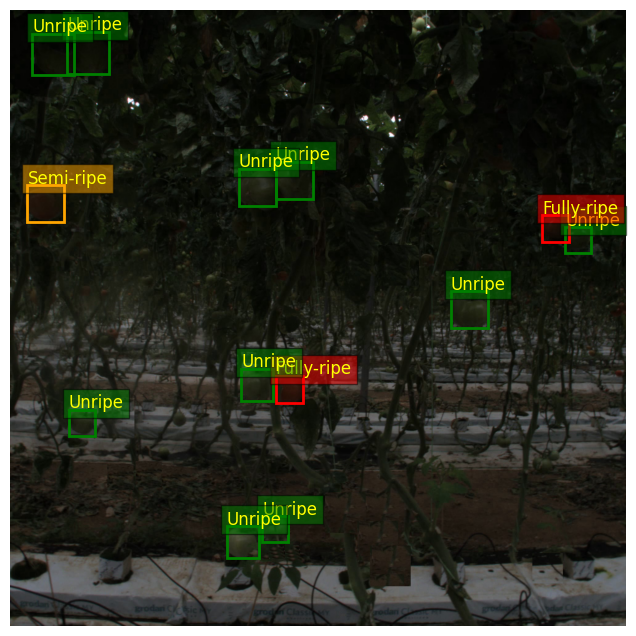

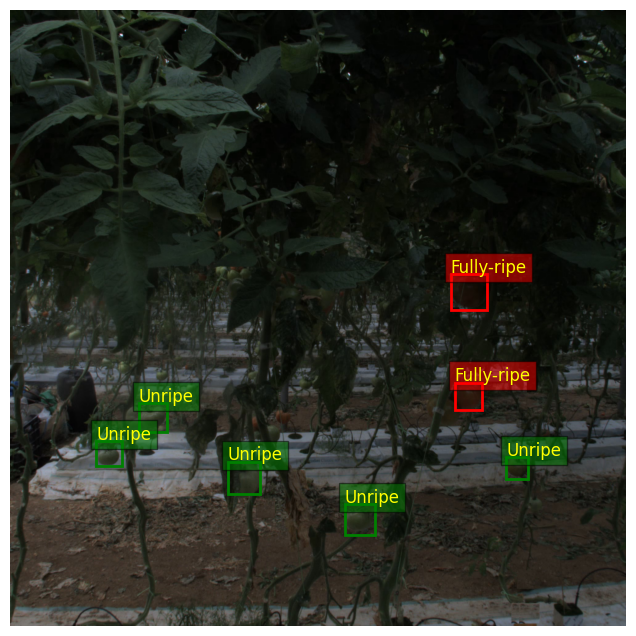

In [27]:
# Example: Display an image from the train DataLoader
for images, targets in train_loader:
    visualize(images[0], targets[0]['boxes'], targets[0]['labels'])
    break

# Example: Display an image from the test DataLoader
for images, targets in test_loader:
    visualize(images[0], targets[0]['boxes'], targets[0]['labels'])
    break